# Visualization and Analysis for hybrid perovskite single crystal data
    ## Author: Zhi Li
    ## Version 1.1
    ## 11-08-2018

In [1]:
import os, fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import axes3d, Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import optunity
import optunity.metrics

## What amines we have tried?

In [2]:
file = "PostRunFulldataset.csv" # data file
df=pd.read_csv(file)
Inchi = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi['Chemical Name'], Inchi['InChI Key (ID)']))

Amine_done = []
for i in df['_rxn_organic-inchikey']:
    if i not in Amine_done: 
        Amine_done.append(i)
Amine_number = len(Amine_done)
for i in range(Amine_number):
    Amine_done[i] = dict(zip(Inchi['InChI Key (ID)'],Inchi['Chemical Name']))[Amine_done[i]]
print (Amine_done)

['Phenethylammonium iodide', 'n-Butylammonium iodide', 'Ethylammonium Iodide', 'Methylammonium iodide', 'Guanidinium iodide', 'Acetamidinium iodide', 'Formamidinium Iodide', 'Imidazolium Iodide']


## 3D plotting function, Convexhull calculation and plotting function (this part should be written into class and its submethod)

In [3]:
# function for specific amine, crystal class
def per3D(points, amine = None, category = None, \
          dim = ['_rxn_M_inorganic', '_rxn_M_organic', '_rxn_M_acid']):
    if amine is not None: amine = Inchidict[amine]
    if amine is None:
        if category is None:
            All_points = np.zeros((points.shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]]
            All_points[:,3] = points['_out_crystalscore']
        else:
            All_points = np.zeros((points[points['_out_crystalscore'] == category].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points['_out_crystalscore'] == category]
            All_points[:,3] = points['_out_crystalscore'][points['_out_crystalscore'] == category]    
    else:
        if category is None:
            All_points = np.zeros((points[points["_rxn_organic-inchikey"] == amine].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points["_rxn_organic-inchikey"] == amine]
            All_points[:,3] = points['_out_crystalscore'][points["_rxn_organic-inchikey"] == amine]
        else:
            All_points = np.zeros((points[points["_rxn_organic-inchikey"] == amine][points['_out_crystalscore'] == category].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points["_rxn_organic-inchikey"] == amine][points['_out_crystalscore'] == category]
            All_points[:,3] = points['_out_crystalscore'][points["_rxn_organic-inchikey"] == amine][points['_out_crystalscore'] == category]
    
    return All_points

# Plot vertice for convexhull
def convexvertice(All_points):
    hull = ConvexHull(All_points[:,0:3]) # remember: last column is crystal score
    # Plot vertices of the convexhull for all classes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for vertice in hull.vertices:
        ax.scatter(All_points[vertice,0],\
                   All_points[vertice,1],\
                   All_points[vertice,2],c = "b")
    ax.set_xlabel("PbI2 (M)")
    ax.set_ylabel("Ammonium Iodide (M)")
    ax.set_zlabel("Formic Acid (M)")
    ax.grid("True")
    return hull.volume

# Plot triangle facet for convexhull
def convexsimplice(categoryA,categoryB):
    hull_A = ConvexHull(categoryA[:,0:3])
    hull_B = ConvexHull(categoryB[:,0:3])
    n_facet_A = np.shape(hull_A.simplices)[0]
    n_facet_B = np.shape(hull_B.simplices)[0]
    facets_A = np.zeros((n_facet_A,3,3))
    facets_B = np.zeros((n_facet_B,3,3))

    for i in range(n_facet_A):
        for j in range(3):
            facets_A[i][j] = categoryA[hull_A.simplices[i][j],0:3] 
    for i in range(n_facet_B):
        for j in range(3):
            facets_B[i][j] = categoryB[hull_B.simplices[i][j],0:3] 
        
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(n_facet_A):
        x = [facets_A[i][0][0],facets_A[i][1][0],facets_A[i][2][0]]
        y = [facets_A[i][0][1],facets_A[i][1][1],facets_A[i][2][1]]
        z = [facets_A[i][0][2],facets_A[i][1][2],facets_A[i][2][2]]
        verts = [list(zip(x, y,z))]
        ax.scatter(x,y,z, c = "blue")
        ax.add_collection3d(Line3DCollection(verts, colors='black', linewidths=1))
    for i in range(n_facet_B):
        x = [facets_B[i][0][0],facets_B[i][1][0],facets_B[i][2][0]]
        y = [facets_B[i][0][1],facets_B[i][1][1],facets_B[i][2][1]]
        z = [facets_B[i][0][2],facets_B[i][1][2],facets_B[i][2][2]]    
        verts = [list(zip(x, y, z))]
        ax.scatter(x,y,z, c = "red")
        ax.add_collection3d(Poly3DCollection(verts,facecolors='red', linewidths=2, alpha=0.2))
        ax.add_collection3d(Line3DCollection(verts, colors='black', linewidths=1))

    plt.show()
    return 

# Check if point is in convexhull
def point_in_hull(point, hull, tolerance = 1e-12):
    return all((np.dot(equ[:-1],point) + equ[-1] <= tolerance) for equ in hull.equations)

# Generate meshgrid points of certain size and location
def gridgen(n=20,x=3,y=4,z=10, plot = False):
    a = np.linspace(0,x,n)
    b = np.linspace(0,y,n)
    c = np.linspace(0,z,n)
    points = np.zeros((n*n*n,3))
    xv,yv,zv = np.meshgrid(a,b,c)
    if plot: 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xv, yv, zv, c = 'coral', s = 5)
    for i in range(n*n*n):
        points[i] = [xv.flatten()[i], yv.flatten()[i], zv.flatten()[i]]
    return points

# Density list calculation, based on nearest neighbor distance:
def density_type1 (point_in_box, point, k = 3):
    density_list = []
    for i in point_in_box:
        distance = cdist([i], point[:,0:3], 'euclidean')
        close_distance = list(distance[0])
        close_distance.sort()
        close_distance = close_distance[0:k]
        density_list.append(np.exp(-sum(close_distance)))
    return density_list

def density_2 (point_in_box, point):
    return

def density_3 (point_in_box, point):
    return

In [184]:
amine_name = "Ethylammonium Iodide" # The ammonium you would like to plot

In [185]:
dictionary = {} # for all subgroup datasets

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


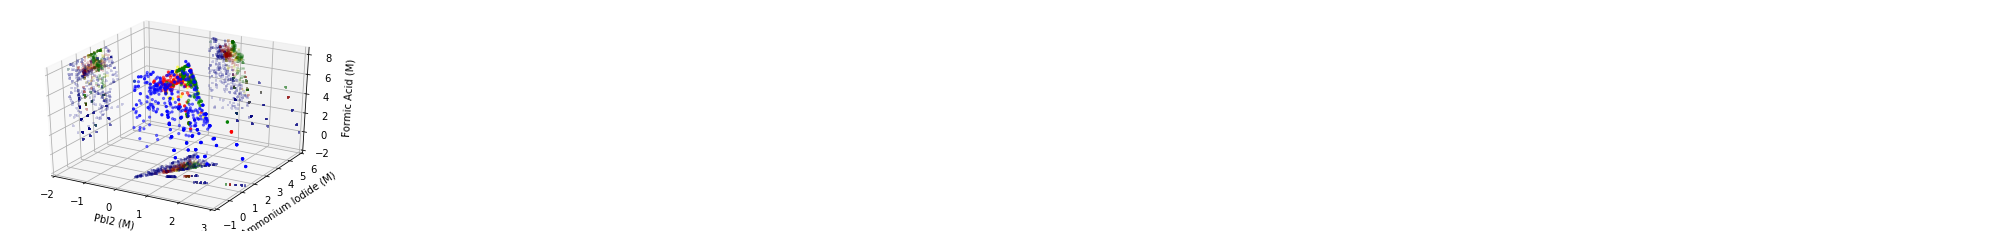

In [186]:
# 3D plot with 2D projection
point = per3D(df,amine = amine_name,category = None)
color_type = ['blue', 'green','yellow','red']
color_type_2D = ['navy', 'darkgreen','y','darkred']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(1,5):
    ax.scatter(point[:,0][point[:,3]==i], \
               point[:,1][point[:,3]==i], \
               point[:,2][point[:,3]==i], \
               c = color_type[i-1], s = 5, alpha=0.5)
    ax.scatter(point[:,0][point[:,3]==i],point[:,2][point[:,3]==i], \
               marker = '+', c = color_type_2D[i-1], s = 8, zdir = 'y', zs = 6, alpha=0.2)
    ax.scatter(point[:,1][point[:,3]==i], point[:,2][point[:,3]==i], \
               marker = '+', c = color_type_2D[i-1], s = 8, zdir = 'x', zs = -2, alpha=0.2)
    ax.scatter(point[:,0][point[:,3]==i], point[:,1][point[:,3]==i], \
               marker = '+', c = color_type_2D[i-1], s = 8, zdir='z', zs = -2, alpha=0.2)
        
ax.set_xlim(-2,3.0)
ax.set_ylim(-1,6.0)
ax.set_zlim(-2,8.5)
ax.set_xlabel("PbI2 (M)", fontsize=10)
ax.set_ylabel("Ammonium Iodide (M)", fontsize=10)
ax.set_zlabel("Formic Acid (M)", fontsize=10)
ax.grid("True")
plt.savefig('Outcome_plot_'+ amine_name + '.png',dpi = 1000)

In [187]:
# Generate meshgrid point
grid_points = gridgen(n=50)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


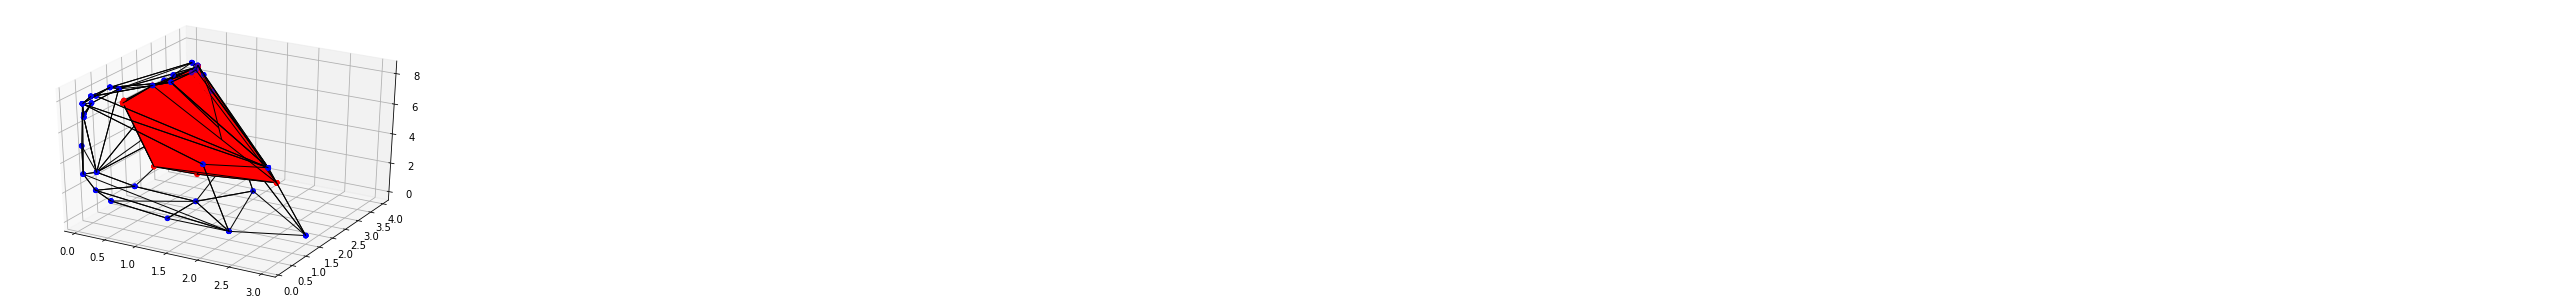

volume of class 4 is 6.702907576353466
volume of class 1-4 is 29.425166869375985
volume percentage for Ethylammonium Iodide is 22.8 %


In [188]:
# Calculate convexhull for class4 and total
point_1 = per3D(df,amine = amine_name, category = 1)
point_2 = per3D(df,amine = amine_name, category = 2)
point_3 = per3D(df,amine = amine_name, category = 3)
point_4 = per3D(df,amine = amine_name, category = 4)
point_all = per3D(df,amine = amine_name)
convexsimplice(point_all, point_4)
hull_1 = ConvexHull(point_1[:,0:3])
hull_2 = ConvexHull(point_2[:,0:3])
hull_3 = ConvexHull(point_3[:,0:3])
hull_4 = ConvexHull(point_4[:,0:3])
hull_all = ConvexHull(point_all[:,0:3])
vol_percentage = round((hull_4.volume/hull_all.volume)*100,1)
print("volume of class 4 is", hull_4.volume)
print("volume of class 1-4 is", hull_all.volume)
print("volume percentage for " + amine_name + " is " + str(vol_percentage) +" %")

In [166]:
np.shape(point_all)

(384, 4)

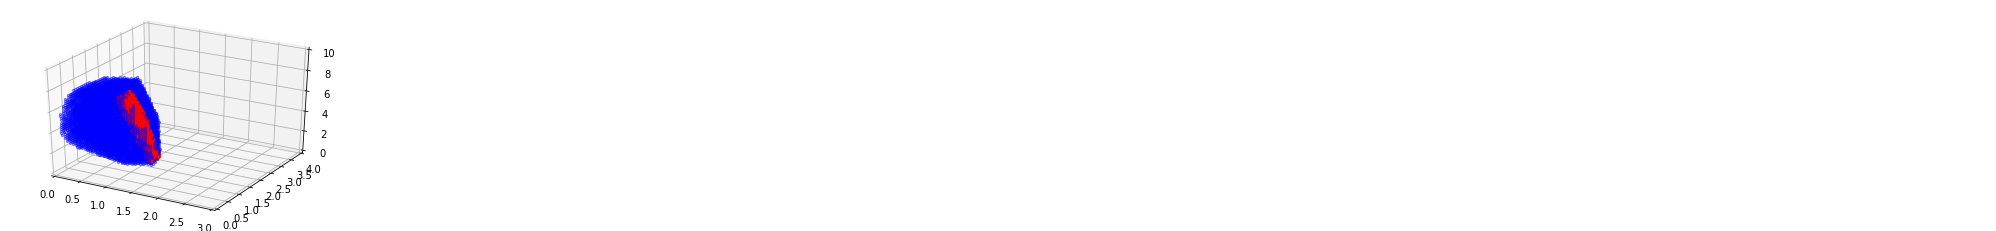

In [167]:
# Search and plot meshgrid points in class4 hull and total hull (also find meshgrid point in other hulls)
point_in_box_1 = []
point_in_box_2 = []
point_in_box_3 = []
point_in_box_4 = []
point_in_box_all = []

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in grid_points:
    if point_in_hull(j, hull_all):
        point_in_box_all.append(list(j))
        if point_in_hull(j, hull_4):
            point_in_box_4.append(list(j))
            ax.scatter(j[0], j[1], j[2], c = 'red', s = 5)
        elif point_in_hull(j, hull_all):
            ax.scatter(j[0], j[1], j[2], c = 'blue', alpha = 0.4, s = 5)
        if point_in_hull(j, hull_3):
            point_in_box_3.append(list(j))
        if point_in_hull(j, hull_2):
            point_in_box_2.append(list(j))
        if point_in_hull(j, hull_1):
            point_in_box_1.append(list(j))
            
ax.set_xlim(0,3)
ax.set_ylim(0,4)
ax.set_zlim(0,10)
plt.savefig('ConvexHull_grid_'+ amine_name + '.png',dpi = 1000)

## Calculate density for class4 and total (You have to have same density calculation method for both class 4 and total)
density_4 = density_type1(point_in_box = point_in_box_4, point = point_4, k = 3)
density_all = density_type1(point_in_box = point_in_box_all, point = point_all, k = 3)
mass = sum(density_4)
mass_all = sum(density_all)
mass_percentage = round(mass/mass_all*100,2)
print("mass of class 4 is", mass)
print("mass of class 1-4 is", mass_all)
print("mass percentage of 4 out of all classes is " + str(mass_percentage) + "%")

## Plot the density distripution for class 4 (using method 1)
point_in_box_4 = np.array(point_in_box_4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(point_in_box_4[:,0], point_in_box_4[:,1], point_in_box_4[:,2], c = density_4, cmap = 'hsv', s = 5, alpha = 0.75)
ax.set_xlim(0,3)
ax.set_ylim(0,4)
ax.set_zlim(0,10)
## fig.colorbar(img)
plt.savefig('density'+ amine_name + '.png',dpi = 1000)

In [168]:
# Building distance matrix (# meshgrid point in class 4 convexhull X # all point)
distance = cdist(point_in_box_4, point_all[:,0:3], 'euclidean') # Calculate the distance between meshgrid point and all class in class 4 convexhull
distance_class_ = np.concatenate((distance, [point_all[:,3]]), axis = 0) # Add the last row as class of all points

In [169]:
k = 5 # number of neighbor is considering
threshold = 2 # dont't know how to use this yet

# Finding the k-nearest neighbors for meshgrid point
vote_list = []
for i in range(np.shape(point_in_box_4)[0]):
    lst = np.zeros((np.shape(point_all)[0],2))
    lst[:,0] = distance[i]
    lst[:,1] = point_all[:,3]
    lst = list(lst)
    lst.sort(key=lambda tup: tup[0])
    lst = np.array(lst[:k])
    if all(list(lst[:,1]).count(4) >= list(lst[:,1]).count(j) for j in [1,2,3]):
        vote_list.append(4) # if vote is 4
    else:
        vote_list.append(0) # if vote is other than 4, set as "0"

point_in_box_4_vote = np.zeros((np.shape(point_in_box_4)[0],4))
point_in_box_4_vote[:,0:3] = point_in_box_4 # coordiation of point in class 4 convexhull
point_in_box_4_vote[:,3] = vote_list # vote of point in class 4 convexhull

In [170]:
# "Fill Factor" (predicted class 4 over all) and "Fuzzy Edege Factor" (predicted non-class 4 over all) calculation.
class4_num = 0
class123_num = 0
for i in point_in_box_4_vote:
    if i[3] == 4:
        class4_num += 1
    else:
        class123_num += 1
FF = round(class4_num/(np.shape(point_in_box_4)[0]),2)
FEF = round(class123_num/(np.shape(point_in_box_4)[0]),2)
print("Fill factor is ", FF)
print("Fuzzy edge factor is ", FEF)

Fill factor is  0.74
Fuzzy edge factor is  0.26


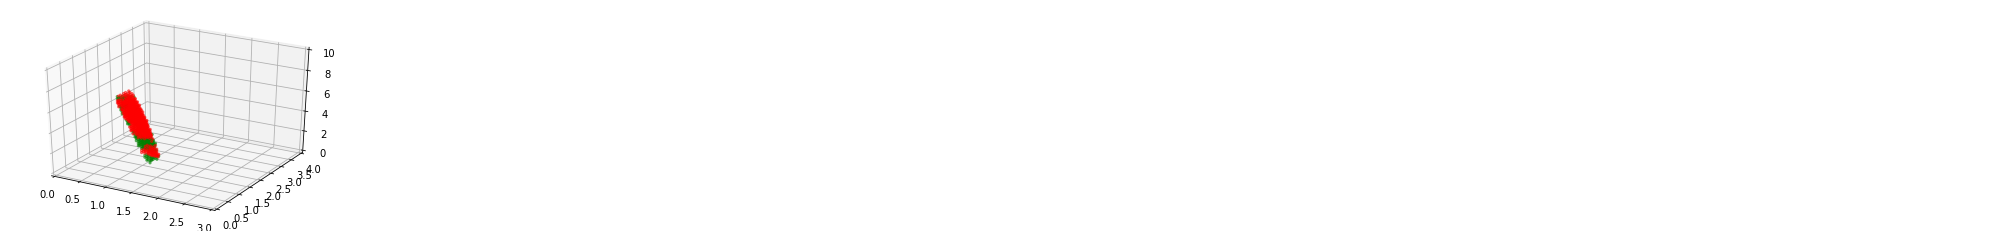

In [171]:
# Plot real class 4 and fake class 4
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(point_in_box_4_vote[:,0][point_in_box_4_vote[:,3] == 4], \
                 point_in_box_4_vote[:,1][point_in_box_4_vote[:,3] == 4], \
                 point_in_box_4_vote[:,2][point_in_box_4_vote[:,3] == 4], \
                 c = "red", s = 5, alpha = 0.5)
img = ax.scatter(point_in_box_4_vote[:,0][point_in_box_4_vote[:,3] == 0], \
                 point_in_box_4_vote[:,1][point_in_box_4_vote[:,3] == 0], \
                 point_in_box_4_vote[:,2][point_in_box_4_vote[:,3] == 0], \
                 c = "green", s = 5, alpha = 0.5)
ax.set_xlim(0,3)
ax.set_ylim(0,4)
ax.set_zlim(0,10)
# fig.colorbar(img)
plt.savefig('patriots and traitors'+ amine_name + '.png',dpi = 1000)

## Clustering of patriots

In [172]:
point_in_box_4_class4 = []
for i in point_in_box_4_vote:
    if i[3] == 4: point_in_box_4_class4.append(i[0:3])
point_in_box_4_class4 = np.array(point_in_box_4_class4)
df_patriot = pd.DataFrame(data = point_in_box_4_class4, columns = ['_rxn_M_inorganic', '_rxn_M_organic', '_rxn_M_acid'])
df_patriot.to_csv('Patriot meshgrid point in class 4 convexhull.csv')

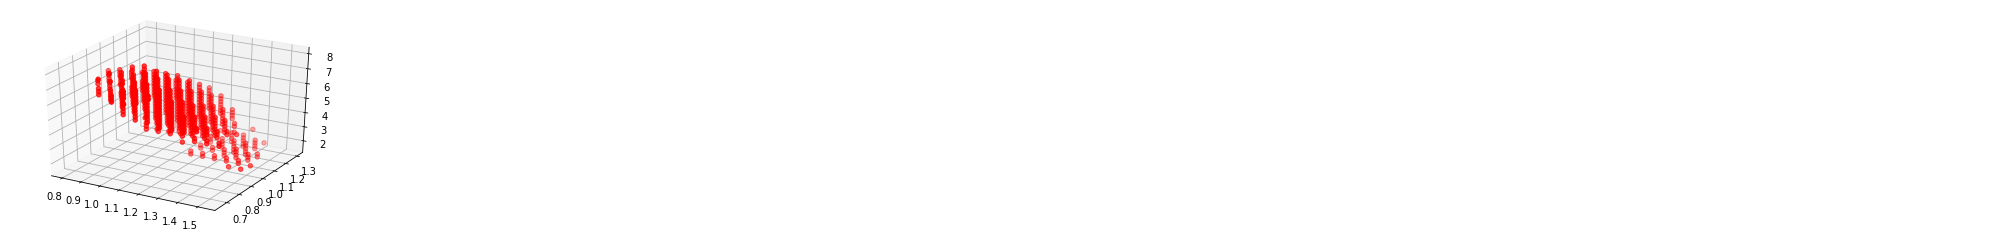

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' )
ax. scatter(point_in_box_4_class4[:,0], point_in_box_4_class4[:,1], point_in_box_4_class4[:,2], c = 'red', s = 20)
plt.savefig('patriots'+ amine_name + '.png',dpi = 1000)

In [174]:
#Clustering using k-means, in order to find mass center
from sklearn.cluster import KMeans
K = 1
clf = KMeans(n_clusters = K)
clf.fit(point_in_box_4_class4)
y_kmeans = clf.predict(point_in_box_4_class4)

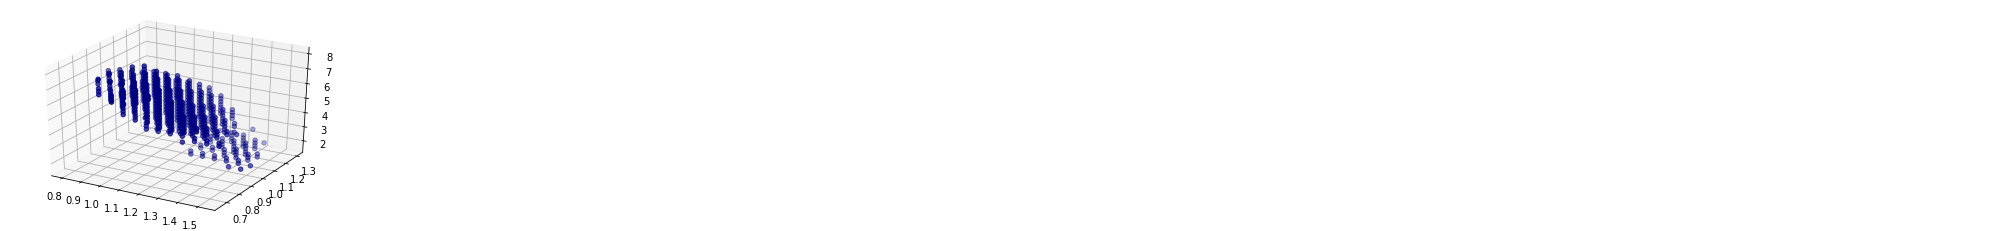

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' )
ax.scatter(point_in_box_4_class4[:,0], point_in_box_4_class4[:,1], point_in_box_4_class4[:,2], c = y_kmeans, cmap = 'jet')
plt.savefig('patriots_clusters'+ amine_name + '.png',dpi = 1000)

In [176]:
clf.cluster_centers_

array([[1.16666128, 0.94543808, 5.21297584]])

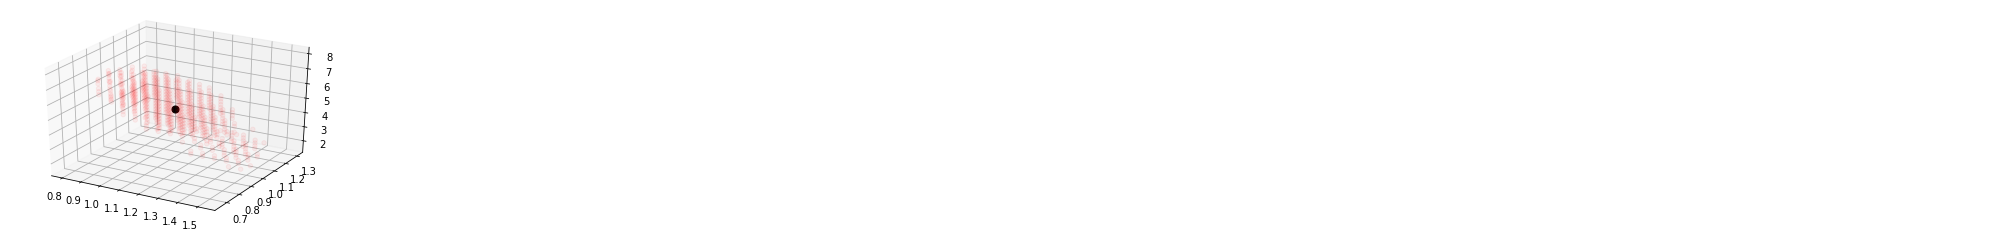

In [177]:
class4_center = clf.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' )
ax. scatter(point_in_box_4_class4[:,0], point_in_box_4_class4[:,1], point_in_box_4_class4[:,2], c = 'red', s = 20, alpha = 0.05)
ax. scatter(class4_center[:,0], class4_center[:,1], class4_center[:,2], c = 'black', s = 50)
plt.savefig('patriots+center'+ amine_name + '.png',dpi = 1000)

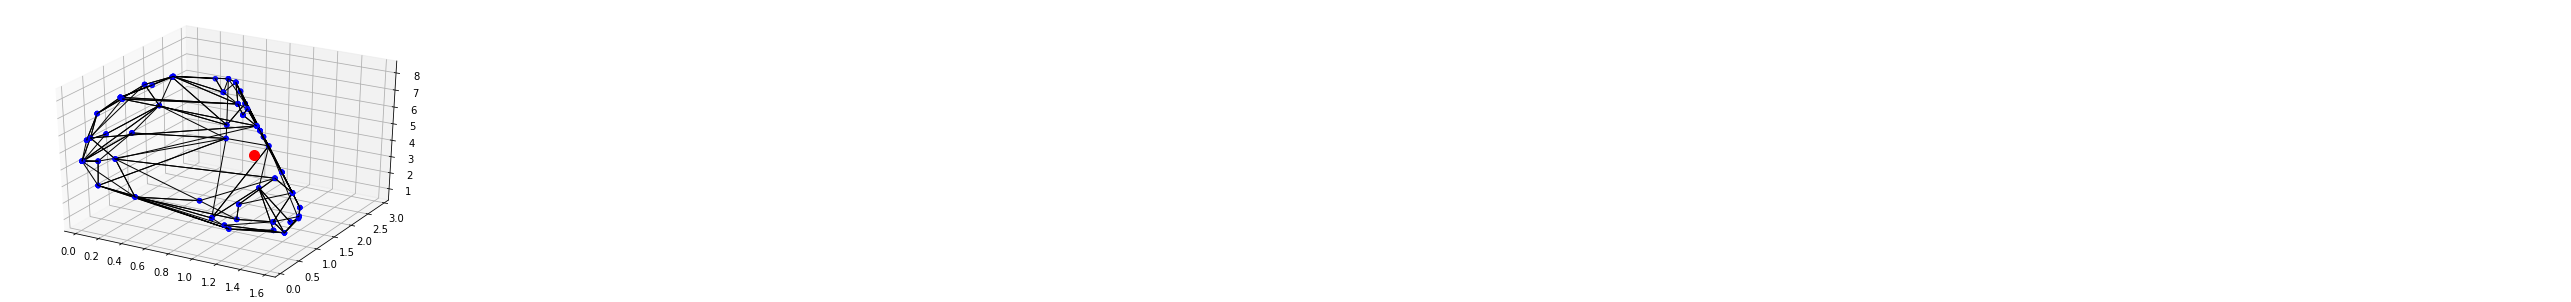

In [178]:
n_facet = np.shape(hull_all.simplices)[0]
facets = np.zeros((n_facet,3,3))

for i in range(n_facet):
    for j in range(3):
        facets[i][j] = point_all[hull_all.simplices[i][j],0:3] 
        
fig = plt.figure()
ax = Axes3D(fig)
for i in range(n_facet):
    x = [facets[i][0][0],facets[i][1][0],facets[i][2][0]]
    y = [facets[i][0][1],facets[i][1][1],facets[i][2][1]]
    z = [facets[i][0][2],facets[i][1][2],facets[i][2][2]]
    verts = [list(zip(x, y, z))]
    ax.scatter(x,y,z, c = "blue")
    ax.add_collection3d(Line3DCollection(verts, colors='black', linewidths=1))
ax. scatter(class4_center[:,0], class4_center[:,1], class4_center[:,2], c = 'red', s = 100)
plt.savefig('convexall + class4center'+ amine_name + '.png',dpi = 1000)
plt.show()